### OFS with sparse gradient
- as given by "An online approach for feature selection for classification in big data"
- no implementation found




In [35]:
#`get mean of dataset
import pandas as pd 
df = pd.read_csv('datasets/binary/shuffle_spambase.csv')
df = df.drop(labels='class', axis=1)
ftr_means = df.mean()
total_mean = ftr_means.mean()


In [36]:
ftr_means

word_freq_make                  0.104553
word_freq_address               0.213015
word_freq_all                   0.280656
word_freq_3d                    0.065425
word_freq_our                   0.312223
word_freq_over                  0.095901
word_freq_remove                0.114208
word_freq_internet              0.105295
word_freq_order                 0.090067
word_freq_mail                  0.239413
word_freq_receive               0.059824
word_freq_will                  0.541702
word_freq_people                0.093930
word_freq_report                0.058626
word_freq_addresses             0.049205
word_freq_free                  0.248848
word_freq_business              0.142586
word_freq_email                 0.184745
word_freq_you                   1.662100
word_freq_credit                0.085577
word_freq_your                  0.809761
word_freq_font                  0.121202
word_freq_000                   0.101645
word_freq_money                 0.094269
word_freq_hp    

In [37]:
import numpy as np

class OFSSGD:
    def __init__(self, reduction_threshold, reduction_value, n_total_ftrs, regularization_param, step_size):
        try:
            if len(reduction_threshold) == n_total_ftrs:
                self.vartheta = reduction_threshold
            else:
                raise ValueError("threshold vector and amount of features is not matching")
        except TypeError as e:
            self.vartheta = np.ones(n_total_ftrs) * reduction_threshold
        self.sigma = reduction_value
        self.W = np.zeros(n_total_ftrs)
        self.regularization_param = regularization_param
        self.step_size = step_size

    def __ola(self, x, y):
        # copied from ofs 
        if np.dot(x, self.W) * y <= 1: # should be 0, shouldn't it
            w_tilde = (1-self.regularization_param * self.step_size)*self.W + self.step_size * y * x
            w_hat = min(1, (1/np.sqrt(self.regularization_param)) / np.linalg.norm(w_tilde) )*w_tilde
            self.W = w_hat
        else:
            self.W *= (1-self.regularization_param*self.step_size)

    def __SGr(self):

        for i in range(len(self.W)):
            if self.W[i] > 0 and self.W[i] < self.vartheta[i]:
                self.W[i] = max(0, self.W[i] - self.sigma)
            elif self.W[i] < 0 and self.W[i] > -self.vartheta[i]:
                self.W[i] = min(0, self.W[i] + self.sigma)


    def train(self, x, y):
        self.__ola(x,y)
        self.__SGr()
            
    def get_weights(self):
        return np.where(self.W != 0)[0]    
        # i suppose that all featurs with weight unequal zero are kept

        

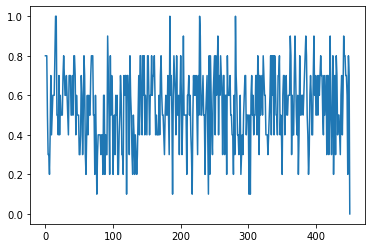

Amount of selected features: 5


In [44]:
import numpy as np
from skmultiflow.data import FileStream
from skmultiflow.neural_networks import PerceptronMask
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

stream = FileStream('datasets/binary/shuffle_spambase.csv', target_idx=57)
stream.prepare_for_use()

x,y = stream.next_sample(batch_size=100)
predictor = PerceptronMask()
predictor.partial_fit(x,y, stream.target_values)

n_selected_ftr = 10

ofssgd = OFSSGD(reduction_threshold=ftr_means, reduction_value=0.2, regularization_param=0.01, step_size=0.2, n_total_ftrs=stream.n_num_features)

accuracy = []

for epoch in range(1):
    while stream.has_more_samples():
        # Load a new sample
        x, y = stream.next_sample(batch_size=10)

        # Select features
        for idx, label in enumerate(y):
            if label == 0:
                label = -1

            ofssgd.train(x[idx],label)

        selected_ftr = ofssgd.get_weights()
        # Truncate x (retain only selected features, 'remove' all others, e.g. by replacing them with 0)
        x_reduced = np.zeros(x.shape)
        x_reduced[:, selected_ftr] = x[:, selected_ftr]

        # Test
        y_pred = predictor.predict(x)
        accuracy.append(accuracy_score(y, y_pred))

        # Train
        predictor.partial_fit(x, y)

    # Restart the FileStream
    stream.restart()

plt.plot(accuracy)
plt.show()
print("Amount of selected features: {}".format(len(selected_ftr)))

In [43]:
selected_ftr

array([ 1, 23, 41, 44, 55])